In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

normalizer = Normalizer()
encoder = OneHotEncoder()
C1 = np.sqrt(2)
K2 = 10
K = 19

In [23]:
class MatMul:
    def __init__(self, X, W):
        self.X = X
        self.W = W

    def forward(self):
        self.Z = self.X@self.W

    def backward(self):
        self.dZ_dW = (self.X).T  
        self.dZ_dO_prev = self.W  


In [24]:
class AddBias : 
    def __init__(self, Z : np.ndarray , bias : np.ndarray ):
        self.B = bias
        self.Z = Z

    def forward(self):
        self.Z = self.Z + self.B
    
    def backward(self):
        self.dZ_dB = np.identity( self.B.shape[1] )

In [25]:
class Activation : 
    def __init__(self, act = "linear", Z = np.random.random((1,1))):
        self.Z = Z
        self.act =  act
        # self.O
    
    def forward(self,):
        if(self.act == 'linear'):
            self.O = self.Z
        elif(self.act == 'sigmoid'):
            self.O = self.sigmoid(self.Z)
        elif(self.act == 'softmax'):
            self.O = self.softmax(self.Z)
        elif(self.act == 'tanh'):
            self.O = np.tanh(self.Z)
    def backward(self,):
        if(self.act == 'linear'):
            self.dO_dZ = np.identity( self.Z.shape[1] )
        elif(self.act == 'sigmoid'):
            diag_entries = np.multiply(self.O, 1-self.O).reshape(-1)
            self.dO_dZ = np.diag(diag_entries)
        elif(self.act == 'softmax'):
            self.dO_dZ = np.diag( self.O.reshape(-1) ) - (self.O.T)@( (self.O))  # Shape = (K,K) where K = len( sZ )
        elif(self.act == 'tanh'):
            self.dO_dZ = np.diag(1 - self.O.reshape(-1)**2)
    def sigmoid(self, Z: np.ndarray):
        return 1./(1 + np.exp(-Z))
    def softmax(self, Z : np.ndarray):
        max_Z = np.max( Z, axis=1 ,keepdims=True )
        return (np.exp(Z - max_Z ))/np.sum( np.exp(Z - max_Z), axis=1 , keepdims=True)

In [26]:
class Loss:
    def __init__(self, Y , Ypred, lossType = "mse",):
        self.Y = Y
        self.O = Ypred
        self.lossType = lossType
    def forward(self):
        if(self.lossType == "mse"):
            self.L = np.mean((self.O - self.Y)**2)
        elif(self.lossType == "ce"):
            self.L = - np.sum(self.Y * np.log(self.O+(1e-40)))
    def backward(self):
        if(self.lossType == "mse"):
            self.dL_dO = (2/len(self.Y))*(self.O - self.Y).T
        elif(self.lossType == "ce"):
            self.dL_dO = -1*(self.Y/(self.O + 1e-40)).T  
        


In [27]:
class Layer:

    def __init__(self, numNeuronsPrev, numNeurons, activation_name="linear", seed=K):
        np.random.seed(seed)  # for reproducability of code

        self.W = np.random.random((numNeuronsPrev, numNeurons)) *  C1/(2*(numNeuronsPrev + numNeurons))
        self.B = np.random.random((1, numNeurons))* C1 / (2*numNeurons)
        self.numNeuronsPrev = numNeuronsPrev
        self.numNeurons = numNeurons
        self.X = np.random.random((1,numNeuronsPrev))   
        self.Z = np.random.random((1, numNeurons))  
        
        if activation_name == 'linear':
            self.layerActivation = Activation("linear",self.Z)
        elif activation_name == 'sigmoid':
            self.layerActivation = Activation("sigmoid",self.Z)
        elif activation_name == 'softmax':
            self.layerActivation = Activation("softmax",self.Z)
        elif activation_name == 'tanh':
            self.layerActivation = Activation("tanh",self.Z)

        # define multiplication layer, bias addition layer , and activation layer
        self.ProductWX = MatMul(self.X, self.W)
        self.AddBtoWX = AddBias(self.B, self.B)


    def forward(self):
        self.ProductWX.X = self.X
        self.ProductWX.forward()

        self.AddBtoWX.Z = self.ProductWX.Z
        self.AddBtoWX.forward()

        self.layerActivation.Z = self.AddBtoWX.Z
        self.layerActivation.forward()
        self.Z = self.layerActivation.O

    def backward(self):
        self.layerActivation.backward()
        self.AddBtoWX.backward()
        self.ProductWX.backward()


In [28]:
class NeuralNetwork(Layer):

    def __init__(self, layers, learning_rate=0.01, loss="mse", seed=K):
        np.random.seed(seed)

        self.listLayers = layers

        self.size_inp = self.listLayers[0].X.shape
        self.size_out = self.listLayers[-1].Z.shape
        
        self.num_layers = len(self.listLayers)  
        self.alpha = learning_rate


        self.X = np.random.random(self.size_inp)   
        self.Y = np.random.random(self.size_out) 

        if loss == "mse":
            self.loss = Loss(self.Y, self.Y, "mse")
        if loss == "ce":
            self.loss = Loss(self.Y, self.Y, "ce")



    def forward(self):
        self.listLayers[0].X = self.X
        self.loss.Y = self.Y

        self.listLayers[0].forward()
        for i in range(1, self.num_layers):
            self.listLayers[i].X = self.listLayers[i-1].Z
            self.listLayers[i].forward()

        self.loss.O = self.listLayers[-1].Z
        self.loss.forward()

    def backward(self):

        self.loss.Z = self.Y
        self.loss.backward()
        self.grad_nn = self.loss.dL_dO
        for i in range(self.num_layers-1, -1, -1):
            self.listLayers[i].backward()

            dL_dZ = np.dot(
                self.listLayers[i].layerActivation.dO_dZ, self.grad_nn)
            dL_dW = np.dot(self.listLayers[i].ProductWX.dZ_dW, dL_dZ.T)
            dL_dB = np.dot(self.listLayers[i].AddBtoWX.dZ_dB, dL_dZ).T

            # Update W & B
            self.listLayers[i].W -= self.alpha*dL_dW
            self.listLayers[i].B -= self.alpha*dL_dB

            # Update outer_grad
            self.grad_nn = np.dot(
                self.listLayers[i].ProductWX.dZ_dO_prev, dL_dZ)

            del dL_dZ, dL_dW, dL_dB


In [29]:
# def create_network(inp_shape, layers_sizes, layers_activations):
#     layers = []
#     n_layers = len(layers_sizes)
#     layer_0 = Layer(inp_shape, layers_sizes[0], layers_activations[0])
#     layers.append(layer_0)
#     inp_shape_next = layers_sizes[0]
#     for i in range(1, n_layers):
#         layer_i = Layer(inp_shape_next, layers_sizes[i], layers_activations[i])
#         layers.append(layer_i)
#         inp_shape_next = layers_sizes[i]

#     out_shape = inp_shape_next
#     return inp_shape, out_shape, layers
def create_network(input_shape, layer_sizes, layer_activations):
    network_layers = []
    num_layers = len(layer_sizes)

    # Create the first layer
    first_layer = Layer(input_shape, layer_sizes[0], layer_activations[0])
    network_layers.append(first_layer)
    next_layer_input_shape = layer_sizes[0]

    # Create subsequent layers
    for i in range(1, num_layers):
        current_layer = Layer(next_layer_input_shape, layer_sizes[i], layer_activations[i])
        network_layers.append(current_layer)
        next_layer_input_shape = layer_sizes[i]

    output_shape = next_layer_input_shape
    return input_shape, output_shape, network_layers


In [30]:
def trainNN(X_train,
                      y_train,
                      X_test,
                      y_test,
                      nn,
                      inp_shape=1,   # dimension of input
                      out_shape=1,   # dimension of output
                      n_iterations=1000,
                      task="regression"  # [ "regression", "classification"]
                      ):

    for _ in range(n_iterations):
        randomIndx = np.random.randint(len(X_train))
        X_sample = X_train[randomIndx, :].reshape(1, inp_shape)
        Y_sample = y_train[randomIndx, :].reshape(1, out_shape)
        nn.X = X_sample
        nn.Y = Y_sample

        nn.forward()  # Forward Pass
        nn.backward()  # Backward Pass
        # print("Loss is ", nn.loss.L)

    # Lets run ONLY forward pass for train and test data and check accuracy/error

    if nn.loss.lossType == "mse":
        nn.X = X_train
        nn.Y = y_train
        nn.forward()
        train_error = nn.loss.L
        nn.X = X_test
        nn.Y = y_test

        nn.forward()

        test_error = nn.loss.L

        print("Mean Squared Loss Error (Train Data)  : %0.5f" % train_error)
        print("Mean Squared Loss Error (Test Data)  : %0.5f" % test_error)

    if nn.loss.lossType == "ce":
        nn.X = X_train
        nn.Y = y_train
        nn.forward()
        print(nn.loss.L)
        y_true = np.argmax(y_train, axis=1)
        y_pred = np.argmax(nn.loss.O, axis=1)
        acc = 1*(y_true == y_pred)
        print("Classification Accuracy (Training Data ): {0}/{1} = {2} %".format(
            sum(acc), len(acc), sum(acc)*100/len(acc)))

        nn.X = X_test
        nn.Y = y_test
        nn.forward()
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(nn.loss.O, axis=1)
        acc = 1*(y_true == y_pred)
        print("Classification Accuracy (Testing Data ): {0}/{1} = {2} %".format(
            sum(acc), len(acc), sum(acc)*100/len(acc)))


In [31]:
normalizer = Normalizer()
raw_df = pd.read_csv("http://lib.stat.cmu.edu/datasets/boston", sep="\s+", skiprows=22, header=None) 
data = {'data': np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]), 'target': raw_df.values[1::2, 2]}
X_train, X_test, y_train, y_test = train_test_split(normalizer.fit_transform(data['data']), data['target'].reshape(-1, 1), test_size=0.2)
print(y_test)

[[26.2]
 [28. ]
 [22.5]
 [32.7]
 [24.5]
 [14.4]
 [18.6]
 [31.5]
 [24. ]
 [23. ]
 [22.2]
 [23.9]
 [32.2]
 [13.9]
 [10.8]
 [15.3]
 [22.6]
 [14.5]
 [24.1]
 [32. ]
 [19.9]
 [18.3]
 [44.8]
 [17.6]
 [29. ]
 [27.5]
 [24.6]
 [12.7]
 [20.4]
 [19.6]
 [43.8]
 [16.5]
 [13. ]
 [20.9]
 [41.3]
 [20.8]
 [18.7]
 [19.5]
 [20.6]
 [20.6]
 [14.6]
 [13.8]
 [19.3]
 [24.8]
 [37.9]
 [50. ]
 [23.3]
 [23.1]
 [16.1]
 [37.3]
 [ 9.6]
 [42.8]
 [ 8.1]
 [21.9]
 [14.6]
 [25.1]
 [23.4]
 [10.2]
 [24.6]
 [24.3]
 [33.8]
 [31.2]
 [28.4]
 [19.5]
 [19.8]
 [11.9]
 [32.9]
 [31.6]
 [17.8]
 [19.9]
 [43.5]
 [50. ]
 [ 7.2]
 [ 9.5]
 [15.6]
 [33.3]
 [17.2]
 [28.7]
 [22.9]
 [19.4]
 [29.6]
 [24. ]
 [37. ]
 [23.6]
 [22.2]
 [23.9]
 [21.1]
 [22.6]
 [18.5]
 [34.9]
 [19.6]
 [50. ]
 [22.4]
 [17.8]
 [33.4]
 [26.6]
 [23.2]
 [18.7]
 [20.1]
 [13.1]
 [12.8]
 [13.4]]


In [32]:
inp_shape = X_train.shape[1]
layers_sizes = [1]
layers_activations = ['linear']

inp_shape, out_shape, layers = create_network(inp_shape, layers_sizes, layers_activations)
loss_nn = 'mse'

nn = NeuralNetwork(layers, 1e-1, loss_nn)

trainNN(X_train,y_train,X_test,y_test,nn,inp_shape, out_shape,n_iterations=11111)

Mean Squared Loss Error (Train Data)  : 59.95095
Mean Squared Loss Error (Test Data)  : 65.52835


In [33]:
inp_shape = X_train.shape[1]
layers_sizes = [13,1]
layers_activations = ['sigmoid','linear']

inp_shape, out_shape, layers = create_network(inp_shape, layers_sizes, layers_activations)
loss_nn = 'mse'

nn = NeuralNetwork(layers, 1e-2, loss_nn)

trainNN(X_train,y_train,X_test,y_test,nn,inp_shape, out_shape,n_iterations=1000)

Mean Squared Loss Error (Train Data)  : 95.01540
Mean Squared Loss Error (Test Data)  : 87.94494


In [34]:
inp_shape = X_train.shape[1]
layers_sizes = [13,13,1]
layers_activations = ['sigmoid','sigmoid','linear']

inp_shape, out_shape, layers = create_network(inp_shape, layers_sizes, layers_activations)
loss_nn = 'mse'

nn = NeuralNetwork(layers, 1e-2, loss_nn)

trainNN(X_train,y_train,X_test,y_test,nn,inp_shape, out_shape,n_iterations=1000)

Mean Squared Loss Error (Train Data)  : 113.99156
Mean Squared Loss Error (Test Data)  : 103.97630


In [35]:
data = load_digits()
data['data'] = 1*(data['data'] >= 10)
X_train, X_test, y_train, y_test = train_test_split( data['data'] , encoder.fit_transform(data['target'].reshape(-1, 1)).toarray(), test_size=0.2)


In [36]:



inp_shape = X_train.shape[1]
layers_sizes = [89,10]
layers_activations = ['tanh','sigmoid']

inp_shape, out_shape, layers = create_network(inp_shape, layers_sizes, layers_activations)
loss_nn = 'mse'

nn = NeuralNetwork(layers, 1e-1, loss_nn)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

trainNN(X_train,y_train,X_test,y_test,nn,inp_shape, out_shape,n_iterations=10000)

(1437, 64)
(360, 64)
(1437, 10)
(360, 10)
Mean Squared Loss Error (Train Data)  : 0.01024
Mean Squared Loss Error (Test Data)  : 0.01658


In [37]:
inp_shape = X_train.shape[1]
layers_sizes = [89,10]
layers_activations = ['tanh','softmax']

inp_shape, out_shape, layers = create_network(inp_shape, layers_sizes, layers_activations)
loss_nn = 'ce'

nn = NeuralNetwork(layers, 1e-2, loss_nn)

trainNN(X_train,y_train,X_test,y_test,nn,inp_shape, out_shape,n_iterations=10000)

358.6386777881987
Classification Accuracy (Training Data ): 1330/1437 = 92.55393180236604 %
Classification Accuracy (Testing Data ): 326/360 = 90.55555555555556 %


In [38]:
class ConvolutionalLayer:

    def __init__(self,
                 inp_shape,
                 activation='tanh',
                 lr=0.01,
                 size_output=1,
                 seed=K2):                                                

        np.random.seed(seed)        

        self.inp = np.random.rand(*inp_shape)
        self.inp_shape = inp_shape
        # number of channels in input here denoted as inp
        self.size_input = self.inp.shape[0]
        # number of output channels
        self.size_output = size_output
        self.filters_shape = (self.size_output, self.size_input,  3, 3)
        self.out_shape = (
            self.size_output, self.inp.shape[1] - 3 + 1, self.inp.shape[2] -3 + 1)
        self.flatten_shape = self.out_shape[0] * \
            self.out_shape[1]*self.out_shape[2]
        self.lr = lr

        # Randomly initialize filters, biases, output, flatten output
        self.filters = np.random.rand(*self.filters_shape)
        self.biases = np.random.rand(*self.out_shape)
        self.out = np.random.rand(*self.out_shape)
        self.flatten_out = np.random.rand(1, self.flatten_shape)

        # Define activation function
        if activation == 'tanh':
            self.activation_layer = Activation("tanh",self.out)
            
    def rotateMatrix(self, mat):
        out = np.zeros(mat.shape)
        N = mat.shape[0]
        M = mat.shape[1]
        for i in range(M):
            for j in range(N):
                out[i, N-1-j] = mat[M-1-i, j]
        return out

    def forward(self, ):
        self.out = np.copy(self.biases)  # add bias to output
        for i in range(self.size_output):
            for j in range(self.size_input):
                self.out[i] += self.convolve(self.inp[j], self.filters[i, j])

        self.flatten()
        self.activation_layer.Z = self.flatten_out
        self.activation_layer.forward()
    


    def backward(self, grad_nn):

        self.activation_layer.backward()
        loss_gradient = np.dot(self.activation_layer.dO_dZ, grad_nn)
        # reshape to (size_output, H_out, W_out)
        loss_gradient = np.reshape(loss_gradient, self.out_shape)

        # dL/dKij for each filter  Kij    1<=i<=size_input , 1<=j<=size_output
        self.filters_gradient = np.zeros(self.filters_shape)
        self.input_gradient = np.zeros(self.inp_shape)  # dL/dXj
        self.biases_gradient = loss_gradient  # dL/dBi  = dL/dYi
        padded_loss_gradient = np.pad(loss_gradient, ((
            0, 0), (self.filters_shape[2]-1, self.filters_shape[2]-1), (self.filters_shape[3]-1, self.filters_shape[3]-1)))

        for i in range(self.size_output):
            for j in range(self.size_input):
                self.filters_gradient[i, j] = self.convolve(self.inp[j], loss_gradient[i]) 
                rot180_Kij = self.rotateMatrix(self.filters[i, j]) # np.rot90(np.rot90(self.filters[i, j], axes=(0, 1)), axes=(0, 1))
                self.input_gradient[j] += self.convolve(padded_loss_gradient[i], rot180_Kij)
        

        # update filters and biases
        self.filters -= self.lr*self.filters_gradient
        self.biases -= self.lr*self.biases_gradient

    # flattening output to 1 Dimension so it can be fed int neural network

    def flatten(self, ):
        self.flatten_out = self.out.reshape(1, -1)

    # convolutional operation with stride=1
    def convolve(self, mat1, mat2, stride=1, pad=0):
        output1 = (mat1.shape[0] + 2*pad - mat2.shape[0])//stride + 1
        output2 = (mat1.shape[1] + 2*pad - mat2.shape[1])//stride + 1
        output_size = (output1, output2)

        mat1=np.pad(mat1, pad)
        output = np.zeros(output_size)

        for i in range(0, output1, stride):
            for j in range(0, output2, stride):
                for k in range(mat2.shape[0]):
                    for l in range(mat2.shape[1]):
                        output[i][j]+=mat1[i+k][j+l]*mat2[k][l]
        return output


In [39]:
def forward(convolutional_layer, network, X, Y):
    # forward pass of convolutional layer 
    convolutional_layer.inp = X 
    convolutional_layer.forward()

    # forward pass of neural network 
    network.X = convolutional_layer.activation_layer.O
    network.Y = Y 
    network.forward()  
    
def backward(network, convolutional_layer): 
    network.backward() 
    convolutional_layer.backward( network.grad_nn )  

In [40]:
def trainCNN(X_train,
            y_train,
            X_test,
            y_test, #cnn,
            convolutional_layer,
            network,
            inp_shape,
            out_shape,
            n_iterations=5000):


    for _ in range(n_iterations):
        randomIndx = np.random.randint(len(X_train))
        X_sample = X_train[randomIndx, :].reshape(inp_shape)
        Y_sample = y_train[randomIndx, :].reshape(out_shape)

        X = X_sample
        Y = Y_sample
        # cnn.X = X_sample
        # cnn.Y = Y_sample

        forward(convolutional_layer, network, X, Y)  # Forward Pass
        # cnn.forward()
        backward(network, convolutional_layer)  # Backward Pass
        # cnn.backward()
    # Lets run ONLY forward pass for train and test data and check accuracy/error
    X_train = X_train.reshape(-1, 8, 8)
    y_true = np.argmax(y_train, axis=1)
    acc = 0
    for i in range(len(X_train)):
        X = X_train[i][np.newaxis, :, :]
        Y = y_train[i]
        forward(convolutional_layer, network, X, Y)
        y_pred_i = np.argmax(network.loss.O, axis=1)
        if (y_pred_i == y_true[i]):
            acc += 1
    
    print("Classification Accuracy (Training Data ):" + str(acc) + "/" + str(len(y_true)) + " = " + str(acc*100/len(y_true)) + " %" )

    X_test = X_test.reshape(-1, 8, 8)
    y_true = np.argmax(y_test, axis=1)
    acc = 0
    for i in range(len(X_test)):
        X = X_test[i][np.newaxis, :, :]
        Y = y_test[i]
        forward(convolutional_layer, network, X, Y)
        y_pred_i = np.argmax(network.loss.O, axis=1)
        if (y_pred_i == y_true[i]):
            acc += 1
    
    print("Classification Accuracy (Testing Data ):" + str(acc) + "/" + str(len(y_true)) + " = " + str(acc*100/len(y_true)) + " %" )


In [41]:
data = load_digits()
data['data'] = 1*(data['data'] >= 8)
X_train, X_test, y_train, y_test = train_test_split( data['data'] , encoder.fit_transform(data['target'].reshape(-1, 1)).toarray(), test_size=0.2)

In [42]:
input_size = (1,8,8)   # sklearn digit dataset has images of shape 1 x 8 x 8
output_size = 16  # 16 channel output 
conv_activation = 'tanh'
convolutional_layer = ConvolutionalLayer(input_size, 
                                        size_output = output_size,
                                        activation = conv_activation,
                                        lr = 0.01)
nn_inp_shape = convolutional_layer.flatten_shape 
layers_sizes = [10]
layers_activations = ['softmax']

_, _, layers = create_network(nn_inp_shape, layers_sizes, layers_activations)

network = NeuralNetwork(layers, 1e-2, 'ce')

out_shape =  (1, layers_sizes[-1])  
trainCNN(X_train,y_train,X_test,y_test,convolutional_layer, network,input_size, out_shape,n_iterations=5000)


Classification Accuracy (Training Data ):1262/1437 = 87.82185107863604 %
Classification Accuracy (Testing Data ):312/360 = 86.66666666666667 %


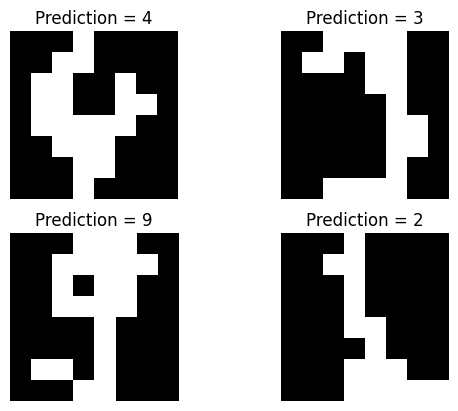

In [43]:
# Code to implement after training

fig,axs = plt.subplots(2,2)
for i in range(4):
    l=i//2
    j=i%2
    k = np.random.randint(len(X_test))
    O = X_test[k].reshape(1, 8, 8)
    network.X = O
    forward(convolutional_layer, network, O, 1)
    mnist_array = O[0]
    axs[l, j].imshow(mnist_array, cmap='gray', interpolation='nearest')
    axs[l, j].axis('off')
    axs[l, j].set_title(f"Prediction = {np.argmax(network.listLayers[-1].Z)}" )

plt.show()
    # 